### Here is the illustration of the framework:
step 1: pre-trained PINN

step 2: POU-RBF for self-adaptive domain decomposition

step 3: FBPINN based on the that domain decomposition

In [1]:
%matplotlib widget           

import jax, jax.numpy as jnp
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

key = jax.random.PRNGKey(0)

### Step 1: Use PINN pre-trained

In [2]:
from physics.problems import Poisson2D_freq68,FirstOrderFreq68, FirstOrderFreq34
from model.pinn_model import PINN
from train.trainer_single  import train_single
problem = FirstOrderFreq34()
u_exact, ansatz, domain,residual_fn = problem.exact, problem.ansatz, problem.domain,problem.residual
from utils.data_utils import generate_collocation

BATCH_SIZE = 3600 # only for pinn full batch
N_COLLOC      = 60 # number of points per dim
STEPS_BASE    = 10000
LR_BASE       = 1e-3

# 1D problem / 2D problem
if isinstance(domain[0], jnp.ndarray) and domain[0].ndim == 1 and domain[0].size == 1:
    xdim = 1
else:
    xdim = 2

print("Dimension is: ",xdim)

mlp_conf = dict(in_size=xdim, out_size=1,
                width_size=128, depth=5,
                activation=jax.nn.tanh)  

key = jax.random.PRNGKey(1)
colloc     = generate_collocation(domain, N_COLLOC, "grid")
base_model = PINN(
    key   = key,
    ansatz  = ansatz, 
    mlp_config  = mlp_conf,
)
test_n = 50
gx = jnp.linspace(domain[0][0], domain[1][0], test_n)
gy = jnp.linspace(domain[0][1], domain[1][1], test_n)
mesh = jnp.meshgrid(gx, gy, indexing="ij")
x_test = jnp.stack([mesh[0].ravel(), mesh[1].ravel()], axis=-1)
base_model, loss_hist_base, (l1_steps_base, l1_hist_base) = train_single(
    model         = base_model,
    colloc        = colloc,
    lr            = LR_BASE,
    steps         = STEPS_BASE,
    pde_residual  = residual_fn,
    #pde_residual  = residual_fn,
    batch_size    = BATCH_SIZE,
    x_test        = x_test,
    u_exact       = u_exact,
    save_dir      = None,
    checkpoint_every = 0,
)

Dimension is:  2


PINN: 100%|██████████| 10000/10000 [00:57<00:00, 172.61it/s, l1=1.18e-02, loss=1.62e-01]


### Visualization of pre-trained PINN

TypeError: expected str, bytes or os.PathLike object, not NoneType

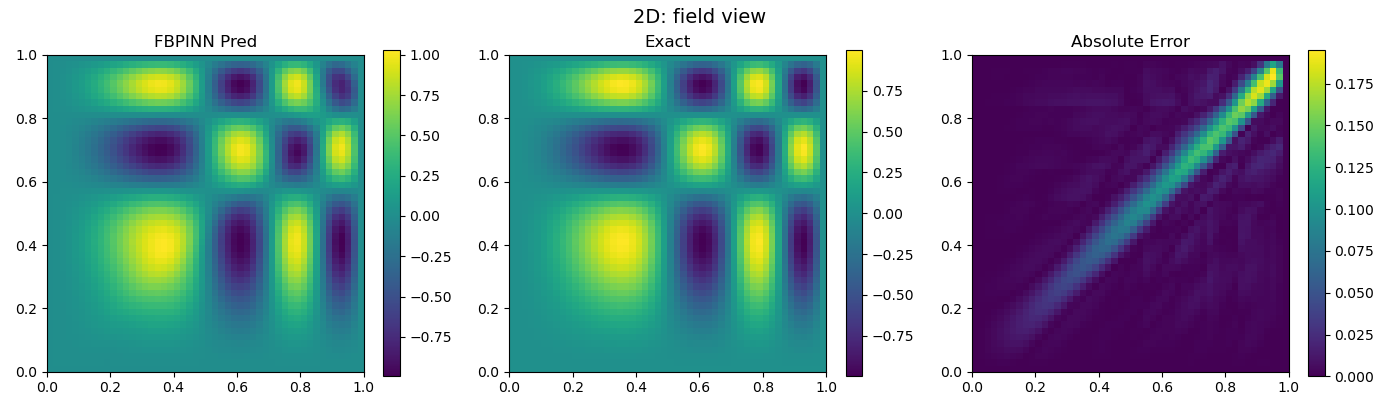

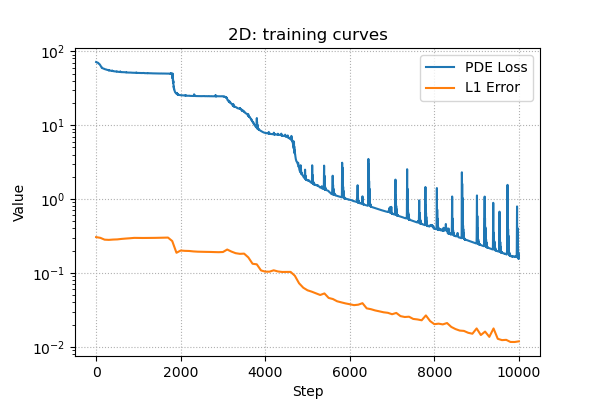

In [3]:
if xdim == 1:                                   # ---- 1-D ----
    from vis.vis_1d import visualize_1d                # ← __init__ 已 re-export

    u_pred = jax.vmap(base_model)(x_test).squeeze()
    u_true = u_exact(x_test).squeeze()

    plot_paths = visualize_1d(
    x_test.squeeze(),
    u_true,
    u_pred,
    loss_hist_base,
    l1_steps_base,
    l1_hist_base,
)
# 2D
else:                                           
    from vis.vis_2d import visualize_2d

    # 还原成 Nx×Ny 网格
    test_n = int(jnp.sqrt(x_test.shape[0]))     # 若 meshgrid 点数可变，自动推断
    grid_x = jnp.linspace(domain[0][0], domain[1][0], test_n)
    grid_y = jnp.linspace(domain[0][1], domain[1][1], test_n)

    u_pred_grid  = jax.vmap(base_model)(x_test).squeeze().reshape(test_n, test_n)
    u_exact_grid = u_exact(x_test).reshape(test_n, test_n)

    plot_paths = visualize_2d(
        base_model,
        grid_x, grid_y,
        u_pred_grid, u_exact_grid,
        loss_hist_base, l1_steps_base, l1_hist_base,
        save_dir=None
    )

### Step 2 POU Network

In [ ]:
#x_train = generate_collocation(domain, 30, "grid")                       # Re‑use collocation grid → (N, 2)
x_train = colloc
y_train = jax.vmap(base_model)(x_train).squeeze()
print("x_train shape:", x_train.shape, "  |  y_train shape:", y_train.shape)

x_train shape: (3600, 2)   |  y_train shape: (3600,)


In [ ]:
from pou_all import _predict_from_coeffs,fit_local_polynomials
from model.POU_nets import BasePOUNet, MLPPOUNet, ResNetPOUNet_Box
import dataclasses
import optax
from vis.vis_pou import viz_partitions,viz_final

def glorot(key, shape):
    fan_in, fan_out = shape
    lim = jnp.sqrt(6. / (fan_in + fan_out))
    return jax.random.uniform(key, shape, minval=-lim, maxval=lim)

import jax, jax.numpy as jnp
from typing import Sequence, Dict, Tuple, Any
# ------------------------------------------------------------------
# 1. 单层 MLP 构造与前向（1-D 版本）
# ------------------------------------------------------------------
def init_mlp_1d(key, hidden: Sequence[int], out_dim: int) -> Dict[str, Any]:
    """返回一个 dict: {'W0':…, 'b0': …, …, 'W_out':…, 'b_out':…}"""
    params = {}
    dims   = [1] + list(hidden) + [out_dim]
    keys   = jax.random.split(key, len(dims) - 1)
    for i, (m, n) in enumerate(zip(dims[:-1], dims[1:])):
        params[f'W{i}'] = glorot(keys[i], (m, n))
        params[f'b{i}'] = jnp.zeros((n,))
    return params


def mlp_forward_1d(params: Dict[str, Any], x: jnp.ndarray) -> jnp.ndarray:
    """x shape (B,1) → logits shape (B,out_dim)"""
    h = x
    n_layer = (len(params) // 2) - 1     # 不含输出层
    for i in range(n_layer):
        h = jnp.tanh(h @ params[f'W{i}'] + params[f'b{i}'])
    return h @ params[f'W{n_layer}'] + params[f'b{n_layer}']


# ------------------------------------------------------------------
# 2. 可分离 POU：MLP_x × MLP_ykey = jax.random.PRNGKey(0)
# ------------------------------------------------------------------
class SepMLPPOUNet:
    """
    Axis-separable POU gate
        w(x,y) = softmax( (MLP_x(x)[:,None] + MLP_y(y)[None,:]) / τ )

    τ (tau) is a **fixed constant** controlling bump width.
    """
    def __init__(
        self,
        nx: int,
        ny: int,
        hidden: Sequence[int] = (32, 32),
        tau: float = 1.0,                           # 固定温度
        key = jax.random.PRNGKey(0)
    ):
        self.nx, self.ny = nx, ny
        self.tau = tau
        kx, ky = jax.random.split(key)
        self.param_x = init_mlp_1d(kx, hidden, nx)
        self.param_y = init_mlp_1d(ky, hidden, ny)

    # ---- 与 BasePOUNet 接口保持一致 ----
    def init_params(self) -> Dict[str, Any]:
        return {'x': self.param_x, 'y': self.param_y}

    def forward(
        self,
        params: Dict[str, Any],
        xy: jnp.ndarray
    ) -> jnp.ndarray:
        """
        xy : (B,2) or (2,)
        return : (B, nx*ny) —— 已做 soft-max 归一化
        """
        if xy.ndim == 1:
            xy = xy[None, :]                          # (1,2)

        x, y = xy[:, :1], xy[:, 1:]                   # (B,1)

        z_x = mlp_forward_1d(params['x'], x)          # (B,nx)
        z_y = mlp_forward_1d(params['y'], y)          # (B,ny)

        # 轴向外加 + 温度缩放
        logits = (z_x[:, :, None] + z_y[:, None, :]) / self.tau  # (B,nx,ny)

        # 数值稳定 soft-max
        logits = logits - jnp.max(logits, axis=(-2, -1), keepdims=True)
        w = jax.nn.softmax(logits.reshape(x.shape[0], -1), axis=-1)  # (B,nx*ny)
        return w

class RBFPOUNet(BasePOUNet):
    def __init__(self, dim: int, num_experts: int, init_width: float = 0.25):
        # ---- 不再调用 super() ----
        self.input_dim   = dim
        self.num_experts = num_experts
        self.init_width = init_width

    # -------- 参数初始化：返回 dict，与旧 run_lsgd 保持一致 --------
    def init_params(self, key: jax.Array = jax.random.PRNGKey(0)):
        k1, k2 = jax.random.split(key)
        # RBF 中心均匀撒在 [0,1]
        c_x = jax.random.uniform(k1,  (self.num_experts,), minval=0., maxval=1.)
        c_y = jax.random.uniform(k2,  (self.num_experts,), minval=0., maxval=1.)
        # σ 存 log 形式确保正数
        log_sx = jnp.full((self.num_experts,), jnp.log(self.init_width))
        log_sy = jnp.full((self.num_experts,), jnp.log(self.init_width))

        return {"c_x": c_x, "c_y": c_y, "log_sx": log_sx, "log_sy": log_sy}

    # -------- 前向：给定 params 与坐标 xy，输出权重矩阵 (B,N) --------
    def forward(self, params: dict, xy: jax.Array) -> jax.Array:
        if xy.ndim == 1:                       # 支持 (2,) 标量点
            xy = xy[None, :]
        x, y = xy[:, 0:1], xy[:, 1:2]          # (B,1)

        # broadcast 形状：(B,N)
        phi_x = jnp.exp(-0.5 * ((x - params["c_x"]) /
                                jnp.exp(params["log_sx"])) ** 2)
        phi_y = jnp.exp(-0.5 * ((y - params["c_y"]) /
                                jnp.exp(params["log_sy"])) ** 2)

        w_raw = phi_x * phi_y                  # (B,N)
        w = w_raw / jnp.sum(w_raw, axis=1, keepdims=True)
        return w

### LSGD training loop to learn POU

In [ ]:
@dataclasses.dataclass
class LSGDConfig:
    n_epochs: int   = 5000
    lr: float       = 1e-4
    lam_init: float = 0.01
    rho: float      = 0.99
    n_stag: int     = 100
    prints: int     = 10
    viz_int: int = 200   # None = no plot


def run_lsgd(model: BasePOUNet, params: dict, x, y, cfg: LSGDConfig):
    lam = jnp.array(cfg.lam_init)
    best, stag = jnp.inf, 0
    log_int = max(1, cfg.n_epochs//cfg.prints)

    @jax.jit
    def loss_fn(p, lam_):
        part   = model.forward(p, x)
        coeffs = fit_local_polynomials(x, y, part, lam_)
        pred   = _predict_from_coeffs(x, coeffs, part)
        return jnp.mean((pred - y)**2)

    valgrad = jax.jit(lambda p, l: jax.value_and_grad(
        lambda pp: loss_fn(pp,l))(p))

    opt = optax.adam(cfg.lr); opt_state = opt.init(params)

    print("JIT compiling ...", end="", flush=True)
    loss_val, grads = valgrad(params, lam); print(" done")

    for ep in range(cfg.n_epochs):
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        loss_val, grads = valgrad(params, lam)

        if cfg.viz_int and ep % cfg.viz_int == 0:
            viz_partitions(model, params, title=f"epoch {ep}")

        if ep % log_int == 0:
            print(f"epoch {ep:6d} | loss {loss_val:.6e} | λ={float(lam):.1e}")

        # early‑stop / λ decay
        if loss_val < best - 1e-12:
            best, stag = loss_val, 0
        else:
            stag += 1
        if stag > cfg.n_stag:
            lam *= cfg.rho; stag = 0

    return params

# Stage‑2  Train the chosen POU network
#NET_TAG = "mlp"          # "mlp" | "resnet" | "rbf"
EPOCHS  = 10000
N_SUB   = 4
DIM = 2
#NET_TAG = "resnet"
#net = RBFPOUNet(DIM, num_experts=N_SUB, init_width=0.5)
#net= MLPPOUNet(DIM, num_experts=N_SUB,hidden=(32,32))
#net = ResNetPOUNet_Box(DIM, num_experts=N_SUB, width=16, depth=3, key=key)
#net   = MLPPOUNet_win(DIM, num_experts=N_SUB,hidden=(32,32,32), grid_dims=(3,4))  # 3×4 均匀网格

TAU_FIXED = 1          
#  τ
key = jax.random.PRNGKey(0)          # keep your original seed handling
nx, ny = 2, 2                        # 2 × 2 = 4 windows (example)

net    = SepMLPPOUNet(nx, ny,
                      hidden=(16, 16),
                      tau=TAU_FIXED,     # ← NEW: fixed temperature
                      key=key)

net.input_dim = 2
params = net.init_params()    # ← dict 结构，满足 run_lsgd 的接口

#cfg    = LSGDConfig(n_epochs=30000, viz_int=500)    
cfg    = LSGDConfig(n_epochs=EPOCHS,
                    viz_int=500 if DIM == 2 else None)

# Train LSGD to get POU parameters
pou_params = run_lsgd(net, params, x_train, y_train, cfg)

# Visualize Stage-2 results
viz_partitions(net, pou_params, title="Stage-2 Learned Partitions")
viz_final(net, pou_params, x_train, y_train)

# Compute and print metrics
final_parts  = net.forward(pou_params, x_train)
final_coeffs = fit_local_polynomials(x_train, y_train, final_parts)
final_pred   = _predict_from_coeffs(x_train, final_coeffs, final_parts)

mse = jnp.mean((final_pred - y_train)**2)
print(f"Stage-2 final MSE on train set = {mse:.3e}")
print("First 5 samples: [y_true, y_pred]")
print(jnp.stack([y_train[:5], final_pred[:5]], axis=1))
print("Corresponding partition weights for first 5 samples:")
print(final_parts[:5])# Stage‑3   Use learned POU as window_fn inside a *new* FBPINN

JIT compiling ... done
epoch      0 | loss 1.735821e-01 | λ=1.0e-02
epoch   1000 | loss 1.427003e-01 | λ=1.0e-02
epoch   2000 | loss 1.175697e-01 | λ=1.0e-02
epoch   3000 | loss 1.092773e-01 | λ=1.0e-02
epoch   4000 | loss 1.070122e-01 | λ=1.0e-02
epoch   5000 | loss 1.063328e-01 | λ=1.0e-02
epoch   6000 | loss 1.061266e-01 | λ=1.0e-02
epoch   7000 | loss 1.060751e-01 | λ=1.0e-02
epoch   8000 | loss 1.060662e-01 | λ=1.0e-02
epoch   9000 | loss 1.060636e-01 | λ=1.0e-02
Stage-2 final MSE on train set = 1.056e-01
First 5 samples: [y_true, y_pred]
[[ 0.         -0.44342358]
 [ 0.         -0.39604128]
 [ 0.         -0.3517478 ]
 [ 0.         -0.31054315]
 [ 0.         -0.27242732]]
Corresponding partition weights for first 5 samples:
[[4.98669765e-09 1.31753734e-17 9.99999992e-01 2.64210390e-09]
 [4.98669764e-09 1.38279976e-17 9.99999992e-01 2.77297692e-09]
 [4.98669764e-09 1.46309865e-17 9.99999992e-01 2.93400311e-09]
 [4.98669764e-09 1.56284111e-17 9.99999992e-01 3.13402017e-09]
 [4.98669


--- Visualizing Learned PoU Windows ---


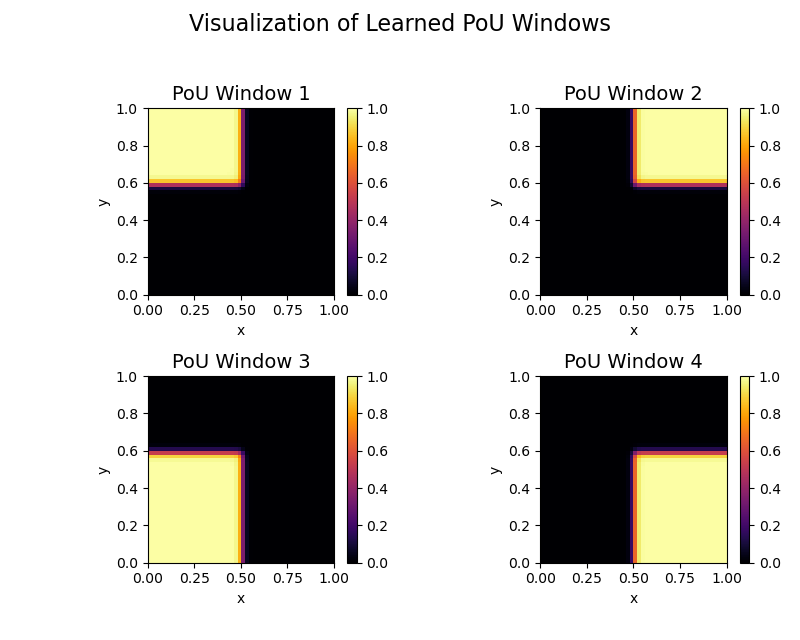


Verifying Partition of Unity property:
Sum of weights for first 5 points: [1. 1. 1. 1. 1.]
Mean of weight sums over all points: 1.000000
Std dev of weight sums over all points: 0.000000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# --- 可视化学习到的 PoU 窗函数 ---

print("\n--- Visualizing Learned PoU Windows ---")

# 1. 在测试网格上计算所有 PoU 窗函数的权重
# net 和 pou_params 来自于 Stage-2 的训练结果
# x_test 是你为最终评估创建的测试网格
pou_weights = net.forward(pou_params, x_test)

# pou_weights 的形状是 (num_points, num_windows), 例如 (2500, 4)
num_windows = N_SUB # N_SUB 是你的子域数量，例如 4

# 2. 创建子图以便并列显示每个窗函数
# 假设 N_SUB=4，我们创建一个 2x2 的网格
# 如果 N_SUB 是其他值，你可能需要调整布局
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.2*rows))  # 16×9.6 in
axes = axes.ravel()

fig.suptitle("Visualization of Learned PoU Windows", fontsize=16)

# 定义绘图范围
extent = [domain[0][0], domain[1][0], domain[0][1], domain[1][1]]

# 3. 循环绘制每一个窗函数
for i in range(num_windows):
    # 提取第 i 个窗函数的权重，并 reshape 成 2D 网格
    window_i_weights = pou_weights[:, i]
    window_i_grid = window_i_weights.reshape(test_n, test_n)
    
    # 在对应的子图上绘制
    ax = axes[i]
    im = ax.imshow(window_i_grid, extent=extent, origin='lower', cmap='inferno', vmin=0, vmax=1)
    ax.set_title(f"PoU Window {i+1}", fontsize=14)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# (可选) 验证 PoU 属性：所有窗函数权重之和应该处处为 1
sum_of_weights = np.sum(pou_weights, axis=1)
print(f"\nVerifying Partition of Unity property:")
print(f"Sum of weights for first 5 points: {sum_of_weights[:5]}")
print(f"Mean of weight sums over all points: {np.mean(sum_of_weights):.6f}")
print(f"Std dev of weight sums over all points: {np.std(sum_of_weights):.6f}")

In [4]:
from model.Networks import FCN
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
from typing import Tuple, Callable
#from model.fbpinn_model import FBPINN_PoU


In [5]:
import os
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt
from tqdm import trange

# (假设你的 FBPINN_PoU, Poisson2D_freq 等类和函数已经定义好)

# --- 核心函数：计算逐点残差和进行RAD采样 ---
# --- 核心函数 (已修正) ---

def pointwise_residual_pou(problem, model, xy):
    """
    计算 FBPINN_PoU 模型在每个点 xy 处的物理残差的绝对值。
    (修正版：不再依赖 get_raw_residuals，而是自行计算)
    """
    # 1. 定义一个辅助函数，用于获取模型在单点的标量输出
    def u_fn(point):
        return model(point).squeeze()

    # 2. JIT-编译Hessian计算，并用vmap并行处理整个批次
    #    Hessian(u) = ∇(∇u)
    hessian_fn = jax.jacfwd(jax.jacrev(u_fn))
    #    vmap并行计算，得到每个点的Hessian矩阵
    hessians = jax.vmap(hessian_fn)(xy)
    
    # 3. 拉普拉斯算子是Hessian矩阵的迹
    #    Δu = trace(Hessian(u))
    laplacians = jnp.trace(hessians, axis1=-2, axis2=-1)

    # 4. 计算残差 |Δu + f| (对于PDE -Δu = f)
    #    problem.rhs(xy) 对应 f(x,y)
    raw_residuals = laplacians + problem.rhs(xy)
    
    return jnp.abs(raw_residuals)

def rad_sample(key, problem, model, *, n_draw, pool_size, k=3.0, c=1.0):
    """
    根据模型残差进行自适应采样。(此函数无需修改)
    """
    (lo, hi) = problem.domain
    pool = jax.random.uniform(key, (pool_size, 2), minval=lo, maxval=hi)
    
    key, sub_key = jax.random.split(key)
    
    res_vals = pointwise_residual_pou(problem, model, pool)
    prob = res_vals**k / jnp.mean(res_vals**k) + c
    prob = prob / prob.sum()
    
    idx = jax.random.choice(sub_key, pool_size, (n_draw,), p=prob, replace=False)
    return pool[idx]

def plot_colloc_points(colloc, domain, stage_id, save_dir="results/rad_stages"):
    """
    绘制并保存在每个RAD阶段采样到的配置点。(此函数无需修改)
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    plt.figure(figsize=(6,6))
    plt.scatter(colloc[:, 0], colloc[:, 1], s=12, alpha=0.6, edgecolors='k', linewidth=0.5)
    plt.xlim(domain[0][0], domain[1][0])
    plt.ylim(domain[0][1], domain[1][1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"RAD Collocation Points (After Stage {stage_id})")
    plt.savefig(os.path.join(save_dir, f"rad_colloc_stage_{stage_id}.png"))
    plt.show()
    
    

In [10]:
from model.fbpinn_model import FBPINN_PoU

def train_fbpinn_pou_rad(
    *,
    key: jax.Array,
    base_model: FBPINN_PoU,          # ① 已经训练过的固定窗口模型
    pou_model:  FBPINN_PoU,          # ② 要训练的“learned-PoU” 模型
    problem:    object,
    # RAD
    stages: int,
    steps_per_stage: int,
    n_colloc: int,
    pool_size: int,
    # 优化 / 评估
    lr: float,
    x_test: jax.Array,
    u_exact: callable,
    eval_every: int = 500,
):
    # ── 1) 以 pou_model 拆分 trainable / static ─────────────────────────
    params, static = eqx.partition(pou_model, eqx.is_array)
    opt = optax.adam(lr)
    opt_state = opt.init(params)

    # ── 2) JIT helpers ──────────────────────────────────────────────────
    @eqx.filter_jit
    def loss_fn(p, xb):
        return problem.residual(model=eqx.combine(p, static), xy=xb)

    @eqx.filter_jit
    def step(p, o, xb):
        loss, g = jax.value_and_grad(loss_fn)(p, xb)
        u, o = opt.update(g, o)              # optax.adam
        p = eqx.apply_updates(p, u)
        return p, o, loss

    @eqx.filter_jit
    def l1_fn(p):
        m = eqx.combine(p, static)
        pred = jax.vmap(m)(x_test).squeeze()
        return jnp.mean(jnp.abs(pred - u_exact(x_test).squeeze()))

    # ── 3) 初始 collocation —— 用 base_model 的残差抽样 ──────────────────
    key, sub = jax.random.split(key)
    colloc = rad_sample(
        sub, problem, base_model,
        n_draw=n_colloc, pool_size=pool_size
    )
    plot_colloc_points(colloc, problem.domain, stage_id=0)

    # ── 4) 训练循环 ─────────────────────────────────────────────────────
    loss_hist, l1_hist, l1_steps = [], [], []
    total = stages * steps_per_stage
    bar   = trange(total, desc="RAD-PoU", dynamic_ncols=True)

    for g in bar:
        params, opt_state, loss = step(params, opt_state, colloc)
        loss_hist.append(float(loss))

        if (g + 1) % eval_every == 0 or g + 1 == total:
            l1 = float(l1_fn(params))
            l1_hist.append(l1); l1_steps.append(g + 1)
            bar.set_postfix(loss=f"{loss:.2e}", L1=f"{l1:.2e}")
        else:
            bar.set_postfix(loss=f"{loss:.2e}")

        # 每到一个 stage 末尾，用 *当前 pou 模型* 残差再采样一次
        if (g + 1) % steps_per_stage == 0 and (g + 1) < total:
            stage = (g + 1) // steps_per_stage
            key, sub = jax.random.split(key)
            curr_model = eqx.combine(params, static)
            colloc = rad_sample(
                sub, problem, curr_model,
                n_draw=n_colloc, pool_size=pool_size
            )
            plot_colloc_points(colloc, problem.domain, stage_id=stage)

    final_model = eqx.combine(params, static)
    return final_model, jnp.array(loss_hist), (jnp.array(l1_steps), jnp.array(l1_hist))


In [12]:
# 1. (不变) 从 Stage-2 创建 PoU 窗函数
def learned_window_fn(x: jax.Array) -> jax.Array:
    if x.ndim == 1:
        x = x[None, :]
    return net.forward(pou_params, x)

mlp_cfg = dict(in_size=DIM, out_size=1, width_size=64, depth=3,
               activation=jax.nn.tanh)

# 2. 初始化 FBPINN_PoU 模型 (权重是随机的，我们将从这里开始训练)
key, pou_model_key = jax.random.split(key)

pou_fbpinn_model = FBPINN_PoU(
    key=pou_model_key,
    domain=problem.domain,      # (xmin, xmax)
    num_subdomains=N_SUB,       # >1 才算 FB-PINN；==1 自动退化成 PINN
    mlp_config=mlp_cfg,
    ansatz=problem.ansatz,
    residual_fn=problem.residual,
    window_fn=learned_window_fn,  # Make sure this is provided
    # ↓↓↓ 以下参数都可保持默认 ↓↓↓
    # infer_bounds = True,               # 缺省 True，自动网格扫描
    # window_on_physical = False,        # 如果 window 函数吃的已经是全域归一化坐标
    # scan_resolution = 512,
    eps = 1e-8,
)
print("FBPINN_PoU model initialized (local normalisation, learned PoU).")
print("FBPINN_PoU model initialized for training from scratch.")
print("xmins_all:\n", pou_fbpinn_model.xmins_all)
print("xmaxs_all:\n", pou_fbpinn_model.xmaxs_all)

NameError: name 'net' is not defined

# Check the gradient of learned parition of unity

Sum of window weights for each point (should be 1):
[0. 0. 0. ... 0. 0. 0.]


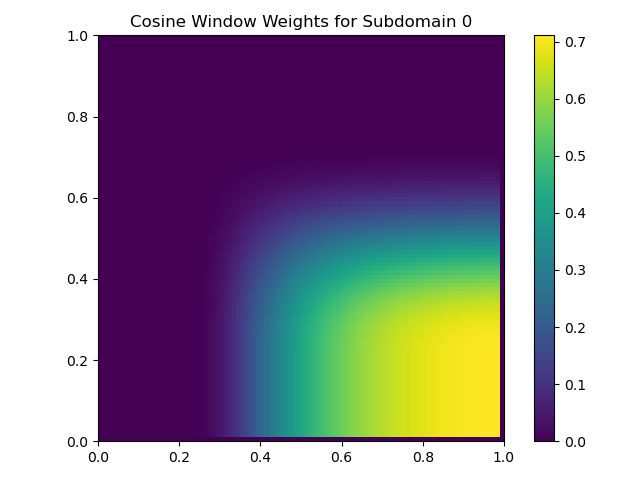

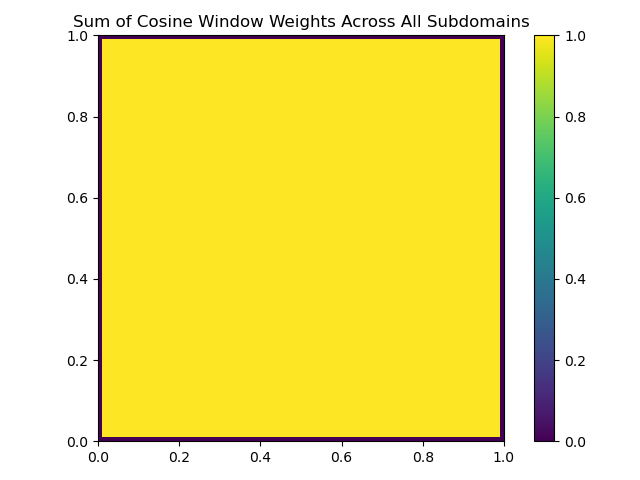

In [77]:
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt

# Assuming you already have the learned xmin and xmax from FBPINN_PoU
xmin_all = pou_fbpinn_model.xmins_all  # Learned xmin values from model
xmax_all = pou_fbpinn_model.xmaxs_all  # Learned xmax values from model

# --- Cosine window function based on learned xmin and xmax ---
def cosine(xmins_all, xmaxs_all, wmins_all, wmaxs_all, x, tol: float = 1e-12):
    """
    Cos² window (C² continuous, FBPINN-style)
    Inputs:
        xmins_all, xmaxs_all : (n_sub, d)
        x                    : (N,d) or (d,)
    Returns:
        w : (N, n_sub)  Normalized window function where sum(w) = 1
    """
    xmins_all = jnp.asarray(xmins_all)
    xmaxs_all = jnp.asarray(xmaxs_all)
    x = jnp.asarray(x)

    if xmins_all.ndim == 1:
        xmins_all = xmins_all[:, None]
        xmaxs_all = xmaxs_all[:, None]

    if x.ndim == 1:
        x = x.reshape(-1, 1)
    elif x.ndim == 0:
        x = x[None, None]

    x_ = x[:, None, :]  # (N, 1, d)
    xmin = xmins_all[None, :, :]  # (1, n_sub, d)
    xmax = xmaxs_all[None, :, :]

    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0

    r = (x_ - mu) / sd  # Normalize to [-1, 1]
    r_clipped = jnp.clip(r, -1.0, 1.0)
    core = ((1.0 + jnp.cos(jnp.pi * r_clipped)) / 2)**2
    w_dim = core

    w_raw = jnp.prod(w_dim, axis=-1)  # (N, n_sub)

    denom = jnp.maximum(w_raw.sum(axis=1, keepdims=True), 1e-12)
    w = w_raw / denom  # (N, n_sub)

    return w

# --- Visualization grid generation ---
NX = NY = 100
grid_x = jnp.linspace(0.0, 1.0, NX)
grid_y = jnp.linspace(0.0, 1.0, NY)
xx, yy = jnp.meshgrid(grid_x, grid_y, indexing="ij")
pts = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)  # (NX*NY, 2)

# --- Visualize the cosine window based on learned xmin and xmax ---
subdomain_idx = 0  # Choose the subdomain index to visualize (can be adjusted)

# Get the learned xmin and xmax for the selected subdomain
xmin = xmin_all[subdomain_idx]
xmax = xmax_all[subdomain_idx]

# Calculate the window weights using the learned xmin and xmax
w_vals_cosine = cosine(xmin_all, xmax_all, None, None, pts)

# Select the first subdomain's weights to visualize (this is an N x 1 array)
w_vals_cosine_single = w_vals_cosine[:, subdomain_idx]

# Reshape to match the grid for visualization
w_img_cosine = w_vals_cosine_single.reshape(NX, NY)

# --- Plot the learned cosine window weights -------------------------------------------
plt.figure()
plt.imshow(w_img_cosine.T, origin='lower', extent=[0, 1, 0, 1])  # Plot the learned cosine window weights
plt.title(f'Cosine Window Weights for Subdomain {subdomain_idx}')
plt.colorbar()
plt.tight_layout()

# --- Check if the sum of the window weights across all subdomains is 1 for each point ---
w_sum = jnp.sum(w_vals_cosine, axis=-1)  # Sum across all subdomains for each point

# Plot the sum of window weights
plt.figure()
plt.imshow(w_sum.reshape(NX, NY).T, origin='lower', extent=[0, 1, 0, 1])
plt.title('Sum of Cosine Window Weights Across All Subdomains')
plt.colorbar()
plt.tight_layout()

# Check if the sum is approximately 1 for each point
print("Sum of window weights for each point (should be 1):")
print(w_sum)  # This will print the sum for each point


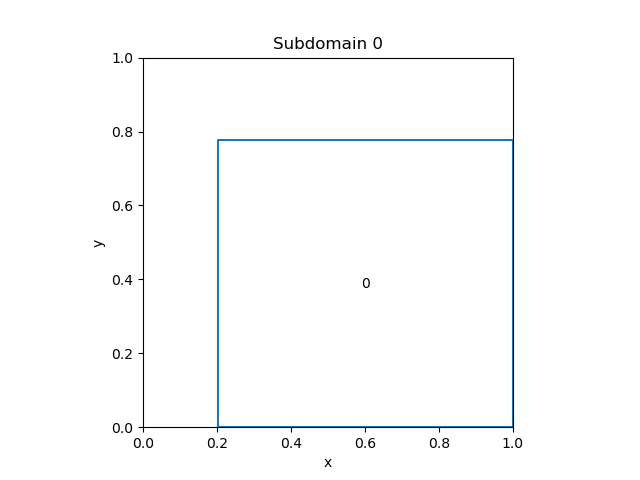

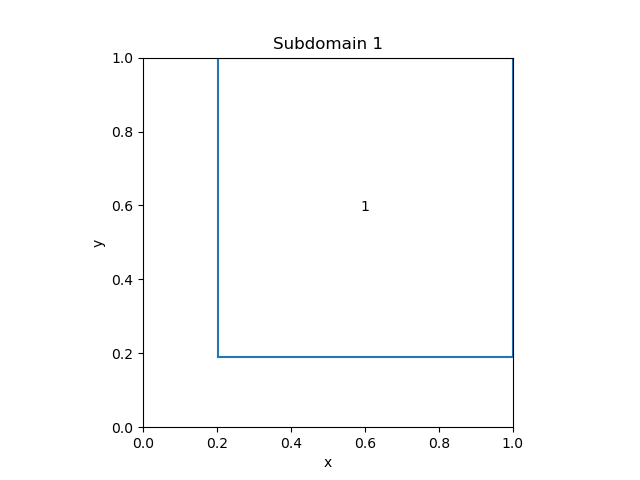

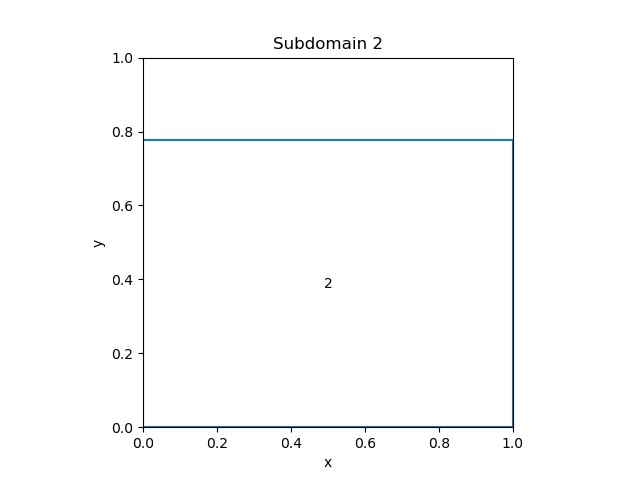

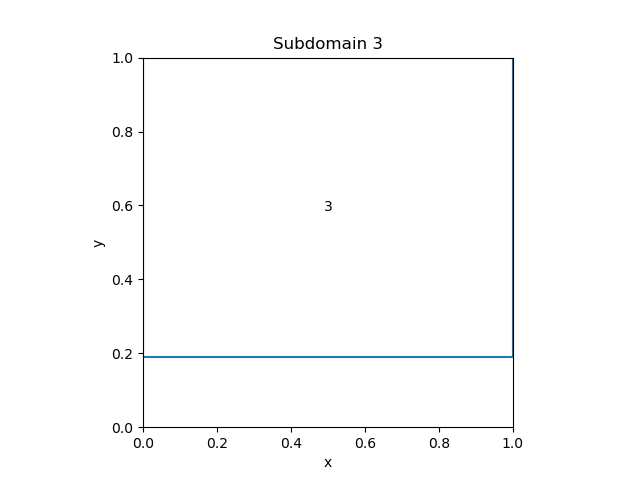

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subdomains_separately(xmins, xmaxs, annotate=True):
    """
    分别绘制每个子域的边界矩形。会为每个子域新建一个独立的 Figure。

    Parameters
    ----------
    xmins, xmaxs : (ns, 2) array-like
        子域最小 / 最大坐标。
    annotate : bool, default True
        是否在框中心写子域索引。
    """
    xmins = np.asarray(xmins)
    xmaxs = np.asarray(xmaxs)
    ns = xmins.shape[0]

    for i in range(ns):
        fig, ax = plt.subplots()

        xmin, ymin = xmins[i]
        xmax, ymax = xmaxs[i]

        # 画矩形边框
        xs = [xmin, xmax, xmax, xmin, xmin]
        ys = [ymin, ymin, ymax, ymax, ymin]
        ax.plot(xs, ys, linewidth=1.5)

        if annotate:
            ax.text((xmin + xmax) / 2, (ymin + ymax) / 2,
                    str(i), ha='center', va='center', fontsize=10)

        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.set_aspect('equal', 'box')
        ax.set_xlabel('x'); ax.set_ylabel('y')
        ax.set_title(f'Subdomain {i}')

        plt.show()   # 每循环一次弹出一张图


# —— 调用示例 —— #
plot_subdomains_separately(pou_fbpinn_model.xmins_all,
                           pou_fbpinn_model.xmaxs_all)


### RAD MANY TIMES

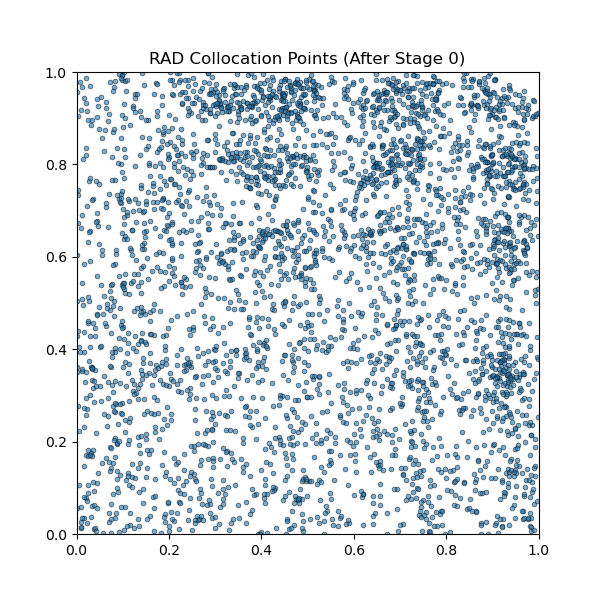

RAD-PoU: 100%|██████████| 10000/10000 [06:53<00:00, 24.19it/s, L1=7.54e-02, loss=1.40e-01] 


In [42]:

# 3. 设置 RAD 训练的超参数
STAGES = 1                  # 共 10 个阶段
STEPS_PER_STAGE = 10000       # 每个阶段训练 1000 步
N_COLLOC_RAD = 3600          # 每个阶段采样的点数 (50*50)
POOL_SIZE = 10000            # 从一个 20000 个点的池中采样
LR_RAD = 1e-3                # 学习率

# 4. 调用新的 RAD 训练器
key, rad_key = jax.random.split(key)
# base_model 已经训练好（固定窗口）
# pou_fbpinn_model 是新建的 “learned-PoU” 网络
trained_rad_model, loss_hist_rad, (l1_steps_rad, l1_hist_rad) = train_fbpinn_pou_rad(
    key              = key,
    base_model       = base_model,         # Stage-1 得到的模型
    pou_model        = pou_fbpinn_model,   # 随机初始 (或已部分预训)
    problem          = problem,
    stages           = STAGES,
    steps_per_stage  = STEPS_PER_STAGE,
    n_colloc         = N_COLLOC_RAD,
    pool_size        = POOL_SIZE,
    lr               = LR_RAD,
    x_test           = x_test,
    u_exact          = u_exact,
    eval_every       = 100,
)


--- Visualizing Training and Test Loss History from RAD Training ---


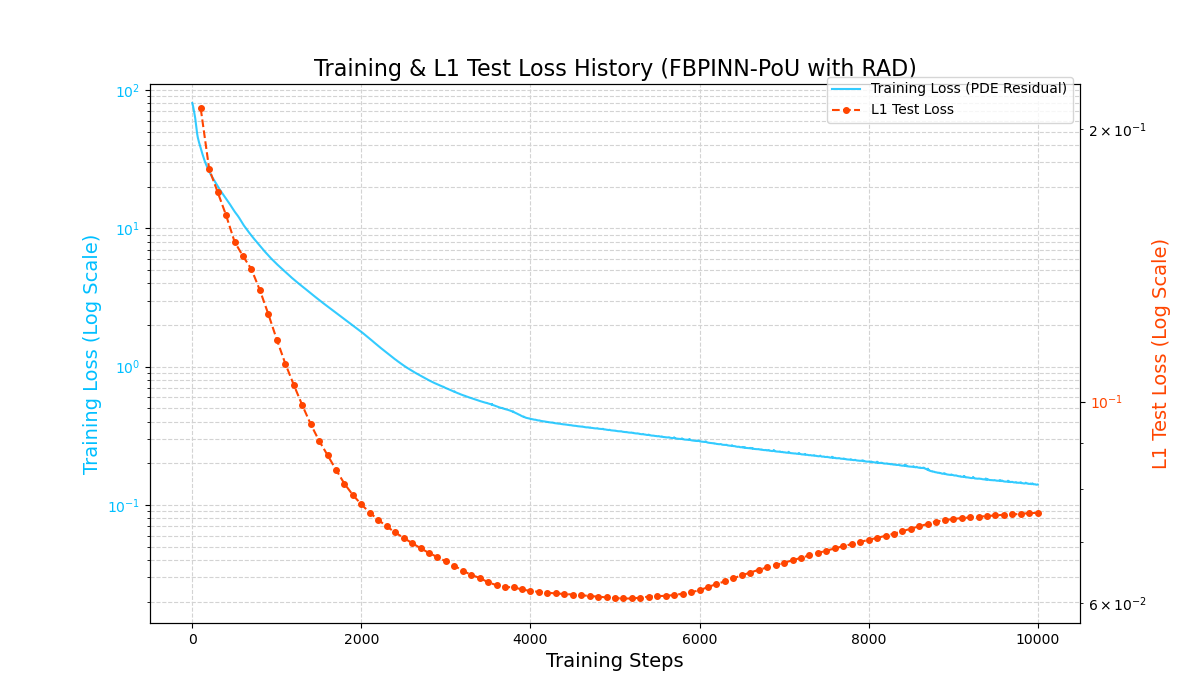

In [43]:
import matplotlib.pyplot as plt
import numpy as np

print("\n--- Visualizing Training and Test Loss History from RAD Training ---")

# 创建一个图形和左侧的 Y 轴
fig, ax1 = plt.subplots(figsize=(12, 7))

# 绘制 Training Loss (使用左边的 Y 轴 ax1)
# loss_hist_rad 的 x 轴是 0, 1, 2, ...
p1, = ax1.plot(loss_hist_rad, color='deepskyblue', label='Training Loss (PDE Residual)', alpha=0.8)
ax1.set_xlabel('Training Steps', fontsize=14)
ax1.set_ylabel('Training Loss (Log Scale)', color='deepskyblue', fontsize=14)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='deepskyblue')
ax1.grid(True, which="both", ls="--", color='lightgrey')
# 可以在 y 轴上添加一个下限，以避免因数值过小导致的显示问题
ax1.set_ylim(bottom=max(1e-7, np.min(loss_hist_rad) / 10))

# 创建共享 x 轴的第二个 Y 轴
ax2 = ax1.twinx()

# 绘制 L1 Test Loss (使用右边的 Y 轴 ax2)
# l1_hist_rad 的 x 轴是 l1_steps_rad
p2, = ax2.plot(l1_steps_rad, l1_hist_rad, color='orangered', linestyle='--', marker='o', markersize=4, label='L1 Test Loss')
ax2.set_ylabel('L1 Test Loss (Log Scale)', color='orangered', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='orangered')

# 添加图例和标题
# 将两个图的图例合并到一个框中
fig.legend(handles=[p1, p2], loc='upper right', bbox_to_anchor=(0.9, 0.9), frameon=True, facecolor='white', framealpha=0.8)
plt.title('Training & L1 Test Loss History (FBPINN-PoU with RAD)', fontsize=16)

plt.show()

u_pred_pou = jax.vmap(trained_rad_model)(x_test).squeeze()
u_true_final = u_exact(x_test).squeeze()

l1_err_pou = float(jnp.mean(jnp.abs(u_pred_pou - u_true_final)))
np.savez("stats_pou.npz",
         loss_hist=loss_hist_rad,
         l1_steps=l1_steps_rad,
         l1_hist=l1_hist_rad,
         u_true_final=u_true_final,
         u_pred_pou=u_pred_pou,
         x_batch_test=x_test)

In [44]:
u_pred_pou = jax.vmap(trained_rad_model)(x_test).squeeze()
u_true_final = u_exact(x_test).squeeze()

l1_err_pou = float(jnp.mean(jnp.abs(u_pred_pou - u_true_final)))

print(f"Stage-3 L1 Error (learned PoU windows): {l1_err_pou:.3e}")

Stage-3 L1 Error (learned PoU windows): 7.539e-02



--- Visualizing Final Results ---


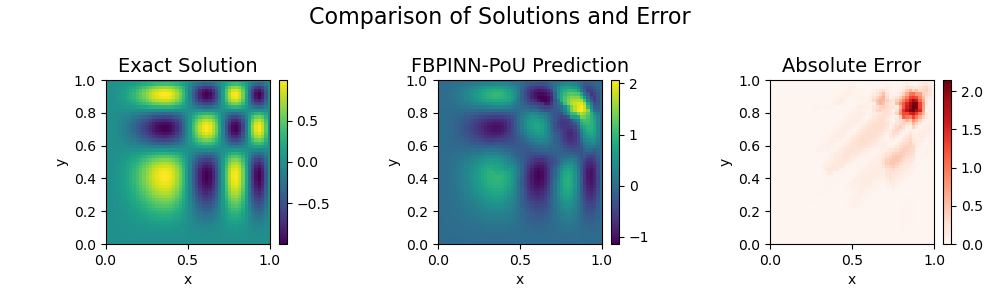


--- Visualizing Training and Test Loss History ---


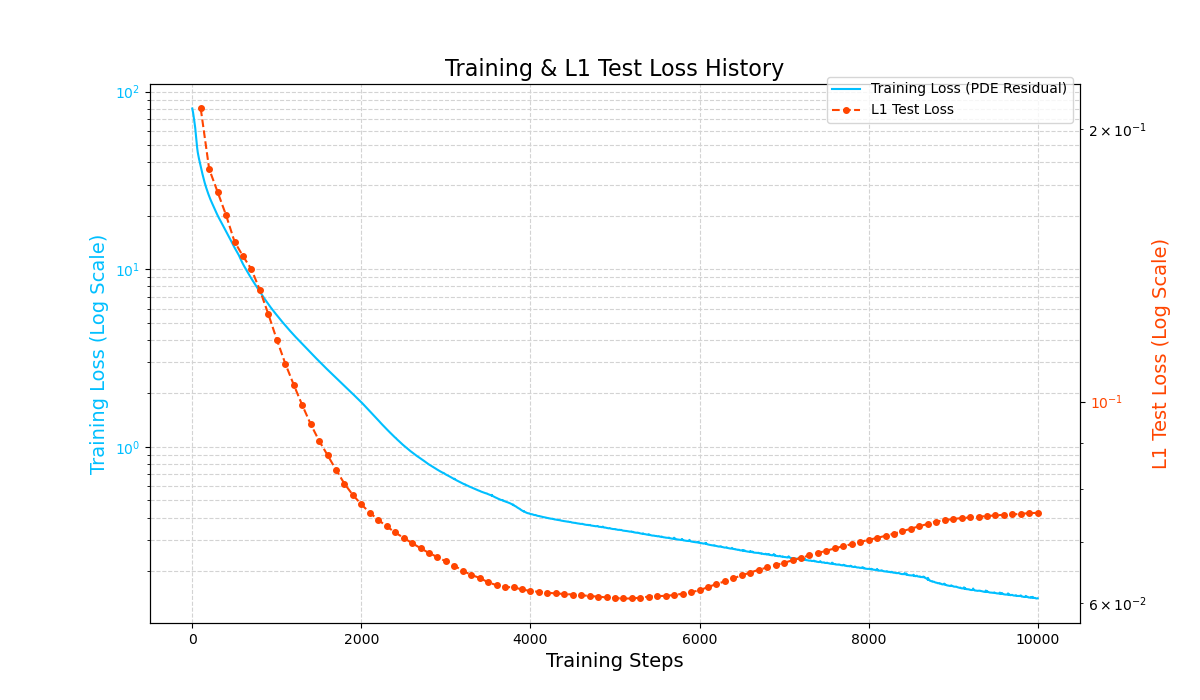

save the stats:


In [45]:
# 5. ✨ 进行最终结果的可视化 ✨
print("\n--- Visualizing Final Results ---")

# `test_n` 是你定义测试网格时的维度，例如 
# 将扁平化的数据重新整形为 2D 网格以便绘图
test_n = 50
U_true_grid = u_true_final.reshape(test_n, test_n)
U_pred_grid = u_pred_pou.reshape(test_n, test_n)
Error_grid = np.abs(U_true_grid - U_pred_grid)

# 创建一个 1x3 的子图
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle("Comparison of Solutions and Error", fontsize=16)

# 定义绘图范围
extent = [domain[0][0], domain[1][0], domain[0][1], domain[1][1]]

# 子图 1: 精确解 (Exact Solution)
im0 = axes[0].imshow(U_true_grid, extent=extent, origin='lower', cmap='viridis')
axes[0].set_title("Exact Solution", fontsize=14)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# 子图 2: FBPINN-PoU 预测解 (Predicted Solution)
im1 = axes[1].imshow(U_pred_grid, extent=extent, origin='lower', cmap='viridis')
axes[1].set_title("FBPINN-PoU Prediction", fontsize=14)
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 子图 3: 绝对误差 (Absolute Error)
im2 = axes[2].imshow(Error_grid, extent=extent, origin='lower', cmap='Reds')
axes[2].set_title("Absolute Error", fontsize=14)
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Visualizing Training and Test Loss History ---")
fig, ax1 = plt.subplots(figsize=(12, 7))
# 绘制 Training Loss (使用左边的 Y 轴)
p1, = ax1.plot(loss_hist_rad, color='deepskyblue', label='Training Loss (PDE Residual)')
ax1.set_xlabel('Training Steps', fontsize=14)
ax1.set_ylabel('Training Loss (Log Scale)', color='deepskyblue', fontsize=14)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='deepskyblue')
ax1.grid(True, which="both", ls="--", color='lightgrey')

# 创建共享 x 轴的第二个 Y 轴
ax2 = ax1.twinx()

# 绘制 L1 Test Loss (使用右边的 Y 轴)
p2, = ax2.plot(l1_steps_rad, l1_hist_rad, color='orangered', linestyle='--', marker='o', markersize=4, label='L1 Test Loss')
ax2.set_ylabel('L1 Test Loss (Log Scale)', color='orangered', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='orangered')

# 添加图例和标题
plt.title('Training & L1 Test Loss History', fontsize=16)
fig.legend(handles=[p1, p2], loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.show()

print("save the stats:")
np.savez("stats.npz",
         loss_hist=loss_hist_rad,       # PDE residual loss over time
         l1_steps=l1_steps_rad,             # test steps at which L1 was recorded
         l1_hist=l1_hist_rad,               # L1 test loss history
         u_true_final=u_true_final,     # 最终测试网格上的真实值
         u_pred_pou=u_pred_pou)         # 最终测试网格上的预测值